In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
from datetime import datetime
neighborhoods = gpd.read_file("SDPD_Beats_shapefile/SDPD_Beats.shp")
neighborhoods['area'] = neighborhoods.geometry.area
neighborhoods = neighborhoods[neighborhoods['area'] > 150000]
zones = gpd.read_file("Zoning_Base_SD_shapefile/Zoning_Base_SD.shp")
folder_path = Path('stops_files')
transit_dfs = {}
for file in folder_path.glob("*.txt"):
    df = pd.read_csv(file)
    file_name = str(file.name)
    file_name = file_name.replace('.txt', '')
    transit_dfs[file_name] = df


common_cols = set(transit_dfs['1206'].columns)
for df in transit_dfs.values():
    common_cols = common_cols.intersection(df.columns)
    
for yymm in transit_dfs:
    df = transit_dfs[yymm]
    df = df[list(common_cols)]
    df = df.drop(['stop_code', 'stop_place', 'reference_place', 'parent_station', 'wheelchair_boarding', 'intersection_code', 'stop_name'], axis=1)
    df = df[df['location_type'] == 1]
    #transit_dfs[yymm] = df
transit_gdfs = {}
for yymm in transit_dfs:
    transit_gdfs[yymm] = gpd.GeoDataFrame(transit_dfs[yymm], geometry=gpd.points_from_xy(y=transit_dfs[yymm].stop_lat, x=transit_dfs[yymm].stop_lon), crs="EPSG:4326")

In [155]:
uncounted_zones = zones[zones["ZONE_NAME"].isin(["AR-1-1", "AG-1-1", "AR-1-2"])]
zones_cleaned = zones[~zones["ZONE_NAME"].isin(["AR-1-1", "AG-1-1", "AR-1-2"])]
neighborhoods = neighborhoods.to_crs(zones_cleaned.crs)
neighborhoods_cleaned = gpd.overlay(neighborhoods, uncounted_zones, how='difference')
zones_with_neighborhoods = gpd.overlay(zones_cleaned, neighborhoods_cleaned[['NAME', 'geometry']], how='intersection')
zones_with_neighborhoods = zones_with_neighborhoods.rename(columns={'NAME': 'neighborhood'})
zones_with_neighborhoods['centroid'] = zones_with_neighborhoods.geometry.centroid
zones_centroids = zones_with_neighborhoods.set_geometry('centroid')
zones_centroids['buffer'] = zones_centroids.geometry.buffer(850)
zones_buffers = zones_centroids.set_geometry('buffer')


/var/folders/zf/1s145dnx53b_5zr2zxzzh0bc0000gn/T/ipykernel_32808/271928524.py:4: UserWarning: `keep_geom_type=True` in overlay resulted in 606 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  neighborhoods_cleaned = gpd.overlay(neighborhoods, uncounted_zones, how='difference')
/var/folders/zf/1s145dnx53b_5zr2zxzzh0bc0000gn/T/ipykernel_32808/271928524.py:5: UserWarning: `keep_geom_type=True` in overlay resulted in 23 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  zones_with_neighborhoods = gpd.overlay(zones_cleaned, neighborhoods_cleaned[['NAME', 'geometry']], how='intersection')


In [156]:
counts_zone_based = zones_buffers.drop(['centroid', 'Shape_Leng', 'Shape_Area', 'IMP_DATE'], axis=1)
weight_map = {0: 1, 1: 3}
def nearby_counter(transit_gdf, yymm):
    transit_gdf = transit_gdf.to_crs(zones_cleaned.crs)
    transit_gdf['weight'] = transit_gdf['location_type'].map(weight_map).fillna(1)
    joined = gpd.sjoin(transit_gdf, zones_buffers, how='left', predicate='within')
    count_series = joined.groupby('index_right')['weight'].sum()
    counts_zone_based[yymm] = zones_buffers.index.map(count_series).fillna(0).astype(int)
for yymm in transit_gdfs:
    nearby_counter(transit_gdfs[yymm], yymm)

In [157]:
counts_zone_based.drop('buffer', axis = 1)
counts_zone_based = counts_zone_based.set_geometry('geometry')


In [158]:
def num_cols(row):
    yymm_cols = []
    for col in list(row.index):
        if str(col).isdigit() == True:
            yymm_cols.append(col)
    yymm_cols = sorted(yymm_cols, key=int)
    return row[yymm_cols]

def grp_sorter(row):
    yymm_row = num_cols(row)
    constant = yymm_row.iloc[0]
    for yymm in yymm_row:
        if constant != yymm:
            return 0
    return 1

def trans_sorter(row):
    if row['no_change'] == 0:
        return 0
    else:
        row = num_cols(row)
        if row.iloc[0] == 0:
            return 1
        else:
            return 0
    

In [159]:
counts_zone_based['no_change'] = counts_zone_based.apply(grp_sorter, axis=1)
counts_zone_based['no_transit'] = counts_zone_based.apply(trans_sorter, axis=1)
neighborhoods_cleaned = neighborhoods_cleaned.rename(columns={'NAME':'neighborhood'})

In [160]:
monitor_change = counts_zone_based[(counts_zone_based['no_change'] == 0) & (counts_zone_based['no_transit'] == 0)]
yymm_cols = [col for col in counts_zone_based.columns if str(col).isdigit()]
yymm_cols = sorted(yymm_cols, key=int)
counts_by_neighborhood = counts_zone_based.groupby('neighborhood')[yymm_cols].sum()
neighborhoods_tp = neighborhoods_cleaned[['neighborhood', 'geometry']].merge(counts_by_neighborhood, on='neighborhood', how='inner')


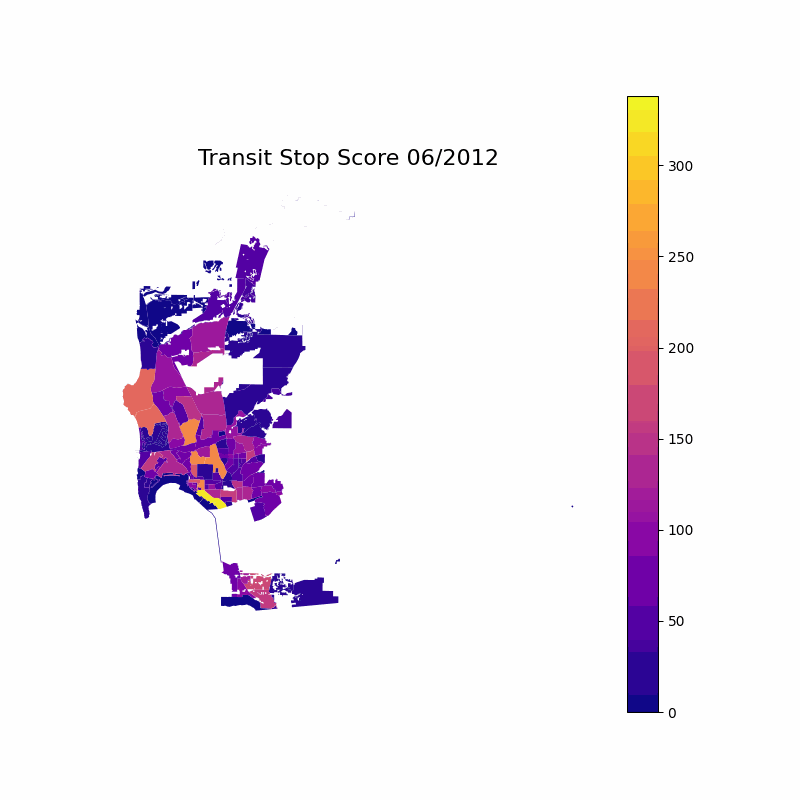

In [162]:
from PIL import Image
import io
from IPython.display import display, Image as IPyImage

global_min = neighborhoods_tp[yymm_cols].min().min()
global_max = neighborhoods_tp[yymm_cols].max().max()

def plot_trans_score(yymm): 
    neighborhoods_tp.plot(column=yymm, cmap='plasma', legend=True, vmin=global_min, vmax=global_max,figsize=(8,8))
    plt.title(f"Transit Stop Score {yymm[2:]}/20{yymm[0:2]}", fontsize=16)
    plt.axis("off")

frames = []

for year in yymm_cols:
    plot_trans_score(str(year))
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    frames.append(Image.open(buf))

gif_buffer = io.BytesIO()
frames[0].save(gif_buffer, format='GIF', append_images=frames[1:], save_all=True, duration=2000, loop=0)
gif_buffer.seek(0)

display(IPyImage(data=gif_buffer.getvalue()))

Now, in an effort to prevent multicollinearity, we have a few groups of zones to look at:
1. no_change = 1, no_transit = 0: This is the group that defines that there is transit in these areas (at least once over the course of the years in the dataset) and that the number of stations has not changed over the course of the years. [1539 obs]
2. no_change = 0, no_transit = 0: This is the group that defines that there is transit in these areas and that there has been change in the number of stations over the years. [880 obs]
3. no_change = 1, no_transit = 1: This is the group that defines that there is no transit in these areas consistently across the years. [2319 obs]